<a href="https://colab.research.google.com/github/alexchtst-01/METR-LA/blob/main/METR-LA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Module

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy as dc

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

### Deeplearning Model and Function

In [23]:
def data_with_lookback(df, n_steps):
    df = dc(df)
    col = df.columns
    df.set_index('Time', inplace=True)
    for i in range(1, n_steps+1):
        df[f'{col[1]}(t-{i})'] = df[f'{col[1]}'].shift(i)

    df.dropna(inplace=True)

    return df

In [24]:
class TimeSeriesData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.reshape(torch.tensor(X), (X.shape[0], X.shape[1]))
        self.y = torch.reshape(torch.tensor(y), (y.shape[0], y.shape[1]))

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [25]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #.to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #.to(device)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [26]:
class GeneralLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GeneralLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

  def forward(self, x):
    out, _ = self.lstm(x)
    return out[:, -1, :]

### Data Preparartion

In [27]:
INDEX_IN_A_DAY = 288
NUMBER_OF_DAYS = 119

lookback = 6
total = INDEX_IN_A_DAY*NUMBER_OF_DAYS - 6
test_len = int(total*0.2)
train_len = total - test_len

ss = StandardScaler()
mm = MinMaxScaler()
kf = KFold(n_splits=6, shuffle=True, random_state=42)

device = "cuda" if torch.cuda.is_available() else "cpu"
modelpath = "/content/drive/MyDrive/model/METR-LA/model3.pt"
device

'cpu'

In [28]:
data716328_path = "/content/drive/MyDrive/data/METR-LA/raw_data/716328.csv"
data716331_path = "/content/drive/MyDrive/data/METR-LA/raw_data/716331.csv"
data716337_path = "/content/drive/MyDrive/data/METR-LA/raw_data/716337.csv"
data716339_path = "/content/drive/MyDrive/data/METR-LA/raw_data/716339.csv"

data716328 = pd.read_csv(data716328_path)
data716331 = pd.read_csv(data716331_path)
data716337 = pd.read_csv(data716337_path)
data716339 = pd.read_csv(data716339_path)

In [29]:
data = data_with_lookback(data716328, lookback)

In [30]:
X, y = data.iloc[:, 1:], data.iloc[:, 0]
X, y  = X.to_numpy(), y.to_numpy().reshape(-1, 1)

# normalize data
X = ss.fit_transform(X)
y = mm.fit_transform(y)

# spliting data
X_train, X_test = X[:train_len, :], X[train_len:, :]
y_train, y_test = y[:train_len], y[train_len:]

In [31]:
X_train.shape

(27413, 6)

## Training Model

In [32]:
LEARNING_RATE = 0.005
EPOCHS = 10
BACTH_SIZE = INDEX_IN_A_DAY

input_size = 6
hidden_size = 5
num_layers = 2
output_size = 1

train_error_store = []
test_error_store = []

In [33]:
train_dataset = TimeSeriesData(X=X_train, y=y_train)
test_dataset = TimeSeriesData(X=X_test, y=y_test)

In [34]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

### General Model

In [35]:
model_general = GeneralLSTM(input_size=input_size, num_layers=num_layers, hidden_size=output_size)
optimizer = optim.Adam(model_general.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [ ]:
for epoch in range(EPOCHS):
    model_general.train(True)
    train_running_loss = 0.0
    for idx, data in enumerate(train_loader):
        seq = data[0].float() #.to(device)
        out = data[1].float() #.to(device)
        optimizer.zero_grad()
        pred = model_general(seq.unsqueeze(0))
        loss = criterion(pred, out)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_error_store.append(train_running_loss / (idx+1))

    model_general.eval()
    eval_running_loss = 0.0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            seq = data[0].float() #.to(device)
            out = data[1].float() #.to(device)
            pred = model_general(seq.unsqueeze(0))
            loss = criterion(pred, out)
            eval_running_loss += loss.item()
        test_error_store.append(eval_running_loss / (idx+1))

    print(f"Epoch: {epoch+1}")
    print(f"train loss: {train_running_loss / (idx + 1)}")
    print(f"test loss: {eval_running_loss / (idx + 1)}")

Epoch: 1
train loss: 0.09423613940191722
test loss: 0.022918004272649072
Epoch: 2
train loss: 0.08053396038065623
test loss: 0.019053165816309798
Epoch: 3
train loss: 0.07965460890885201
test loss: 0.017764447340107285
Epoch: 4
train loss: 0.07894195929945971
test loss: 0.017451876292425773
Epoch: 5
train loss: 0.07835780040257119
test loss: 0.01738145218634282
Epoch: 6
train loss: 0.07789422239086355
test loss: 0.017366123489695306
Epoch: 7
train loss: 0.0777132787259558
test loss: 0.01734093866084774
Epoch: 8
train loss: 0.07754367882215919
test loss: 0.017305972159070083
Epoch: 9
train loss: 0.07742005814714996
test loss: 0.017261757416049565
Epoch: 10
train loss: 0.07731964083129204
test loss: 0.017269584004524496


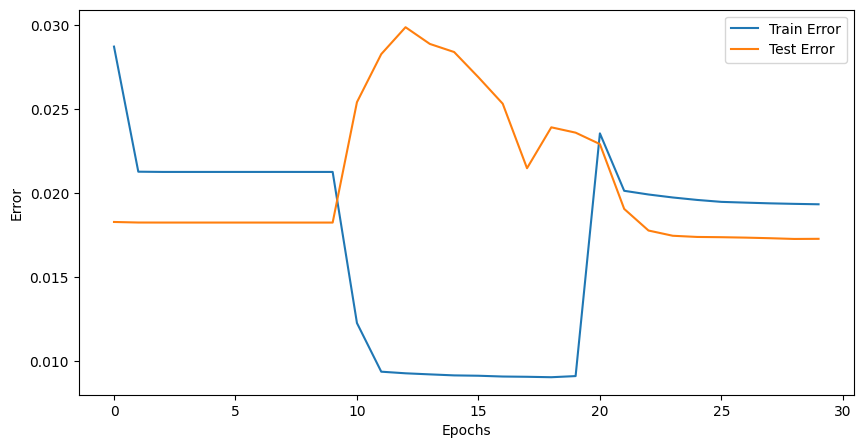

In [ ]:
# Plot the training and test error

plt.figure(figsize=(10, 5))
plt.plot(train_error_store, label='Train Error')
plt.plot(test_error_store, label='Test Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
predictions = []
act_val = []
for idx, data in enumerate(train_loader):
  with torch.no_grad():
      seq = data[0].float() #.to(device)
      pred = model_general(seq.unsqueeze(0))
      act_val.append(data[1].float().cpu().detach().numpy()[0])
      predictions.append(pred.cpu().detach().numpy()[0])

predictions_inverse_scale = mm.inverse_transform(predictions)
actual_value = mm.inverse_transform(act_val)

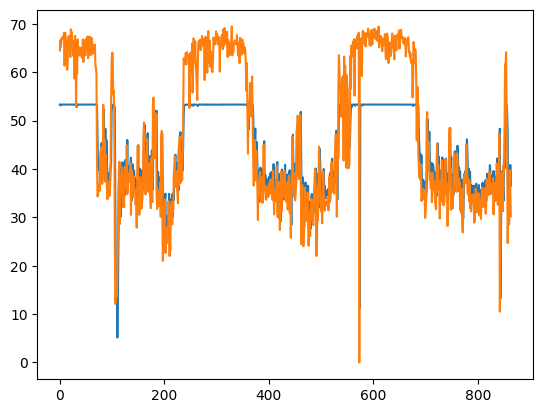

In [ ]:
plt.plot(predictions_inverse_scale[:INDEX_IN_A_DAY*3])
plt.plot(actual_value[:INDEX_IN_A_DAY*3])

### Custom Model

In [ ]:
model = CustomLSTM(input_size, hidden_size, num_layers, output_size) #.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [ ]:
for epoch in range(EPOCHS):
    model.train(True)
    train_running_loss = 0.0
    for idx, data in enumerate(train_loader):
        seq = data[0].float() #.to(device)
        out = data[1].float() #.to(device)
        optimizer.zero_grad()
        pred = model(seq.unsqueeze(0))
        loss = criterion(pred, out)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_error_store.append(train_running_loss / (idx+1))

    model.eval()
    eval_running_loss = 0.0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            seq = data[0].float() #.to(device)
            out = data[1].float() #.to(device)
            pred = model(seq.unsqueeze(0))
            loss = criterion(pred, out)
            eval_running_loss += loss.item()
        test_error_store.append(eval_running_loss / (idx+1))

    print(f"Epoch: {epoch+1}")
    print(f"train loss: {train_running_loss / (idx + 1)}")
    print(f"test loss: {eval_running_loss / (idx + 1)}")

Epoch: 1
train loss: 0.048993500813280334
test loss: 0.025418349596619053
Epoch: 2
train loss: 0.037389696602240396
test loss: 0.028282977508274774
Epoch: 3
train loss: 0.03700435225768517
test loss: 0.02988719833168983
Epoch: 4
train loss: 0.03674792256291086
test loss: 0.028891160828950085
Epoch: 5
train loss: 0.036505755825379786
test loss: 0.028408661225323862
Epoch: 6
train loss: 0.03642199056698189
test loss: 0.02690265605784828
Epoch: 7
train loss: 0.0362342543356783
test loss: 0.025326813275849354
Epoch: 8
train loss: 0.036173118357501005
test loss: 0.021479181771445335
Epoch: 9
train loss: 0.03606881947698242
test loss: 0.023918623570164926
Epoch: 10
train loss: 0.03633969685497902
test loss: 0.023600554357991115


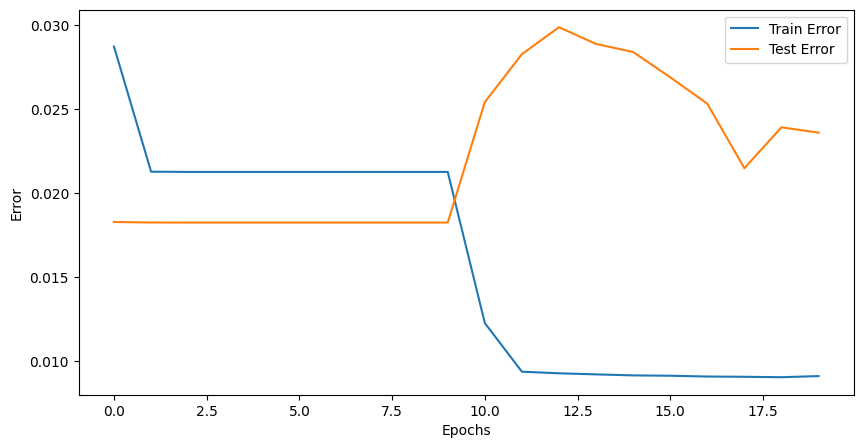

In [ ]:
# Plot the training and test error

plt.figure(figsize=(10, 5))
plt.plot(train_error_store, label='Train Error')
plt.plot(test_error_store, label='Test Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
model.save(custom_model, )

In [ ]:
predictions = []
act_val = []
for idx, data in enumerate(train_loader):
  with torch.no_grad():
      seq = data[0].float() #.to(device)
      pred = model(seq.unsqueeze(0))
      act_val.append(data[1].float().cpu().detach().numpy()[0])
      predictions.append(pred.cpu().detach().numpy()[0])

predictions_inverse_scale = mm.inverse_transform(predictions)
actual_value = mm.inverse_transform(act_val)

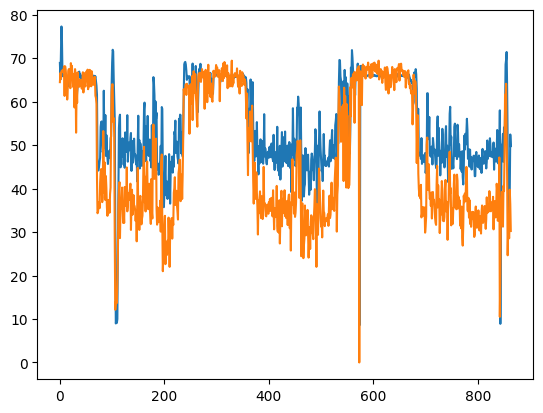

In [ ]:
plt.plot(predictions_inverse_scale[:INDEX_IN_A_DAY*3])
plt.plot(actual_value[:INDEX_IN_A_DAY*3])